In [1]:
%matplotlib inline

from itertools import groupby
import numpy as np
import pandas as pd
import scipy
import scipy.signal

#to visualize 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")


#to load files
import os
import h5py

#ML packages
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold


from tensorflow import keras
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential, Model, load_model, Sequential, save_model
from tensorflow. keras.layers import Dense, Activation, Dropout, Input,  TimeDistributed, GRU, Masking, LSTM

from tensorflow.keras.utils import to_categorical


from sklearn.datasets import make_moons, make_blobs

from EMG_gestures.utils import *

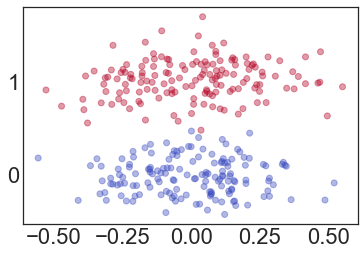

In [2]:
X1, y1 = make_blobs(300, centers=[[0, 0], [0, 1]], cluster_std=0.2)

plt.scatter(X1[:,0], X1[:,1], c=y1, cmap='coolwarm', alpha=0.4)


In [3]:
epochs = 20
batch_size = 5
verbose = 0
score_list = ['f1','accuracy']
nreps = 3
n_splits = 3

In [11]:
X = X1.copy()
y = y1.copy()

In [12]:

skf = StratifiedKFold(n_splits=n_splits)
n_scores = len(score_list)
train_scores = np.empty((n_splits,n_scores))
test_scores = np.empty((n_splits,n_scores))

for split_count,(train_idxs, test_idxs) in enumerate(skf.split(X, y)):
    print('Split Count: %i'% (split_count+1))

#train and testing cubes
X_train_cube, Y_train_cube, scaler = prepare_data_for_log_reg(X,y, train_idxs, [], train = True)
X_test_cube, Y_test_cube, scaler = prepare_data_for_log_reg(X,y, test_idxs, [], train = False, scaler = scaler)

n_features, n_outputs = X_train_cube.shape[1], Y_train_cube.shape[1]

Split Count: 1
Split Count: 2
Split Count: 3


In [13]:
input_shape = (n_features,)
drop_prob = 0.5
n_dense_pre = 1
activation = 'tanh'

In [14]:
model = shallow_NN(input_shape, n_outputs, 0, activation = 'relu')

In [15]:
model.predict_label.summary()

Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
feature_extractor (Functiona (None, 2)                 0         
_________________________________________________________________
label_predictor (Functional) (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [16]:
np.random.seed(1)
model.compile(loss='categorical_crossentropy')#loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary

print('Training Model')
# fit network
history = model.fit(X_train_cube, Y_train_cube, epochs=epochs, batch_size=batch_size, verbose=1)

Training Model
Epoch 1/20
40/40 [==============================] - 1s 1ms/step - mean: 0.7148 - categorical_accuracy: 0.4850
Epoch 2/20
40/40 [==============================] - 0s 2ms/step - mean: 0.6720 - categorical_accuracy: 0.5950
Epoch 3/20
40/40 [==============================] - 0s 1ms/step - mean: 0.6342 - categorical_accuracy: 0.6900
Epoch 4/20
40/40 [==============================] - 0s 2ms/step - mean: 0.5973 - categorical_accuracy: 0.8150
Epoch 5/20
40/40 [==============================] - 0s 2ms/step - mean: 0.5630 - categorical_accuracy: 0.9400
Epoch 6/20
40/40 [==============================] - 0s 2ms/step - mean: 0.5304 - categorical_accuracy: 0.9800
Epoch 7/20
40/40 [==============================] - 0s 1ms/step - mean: 0.4995 - categorical_accuracy: 0.9950
Epoch 8/20
40/40 [==============================] - 0s 1ms/step - mean: 0.4708 - categorical_accuracy: 1.0000
Epoch 9/20
40/40 [==============================] - 0s 1ms/step - mean: 0.4441 - categorical_accuracy: 1.

In [17]:
train_scores = get_scores(X_train_cube, Y_train_cube, model.predict_label, score_list)
test_scores = get_scores(X_test_cube, Y_test_cube, model.predict_label, score_list)

In [18]:
print(train_scores)
print(test_scores)

[1. 1.]
[0.979992 0.98    ]


NameError: name 'tmp' is not defined

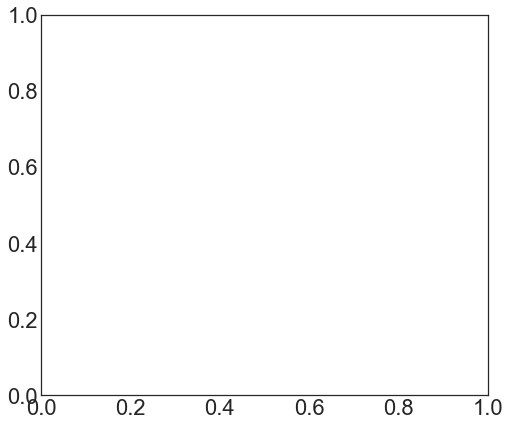

In [19]:
# Set-up grid for plotting.

xx, yy = make_meshgrid(X_train_cube[:,0], X_train_cube[:,1])

fig, ax = plt.subplots(figsize=(8,7))
title = ('Decision boundary of model ')
plot_contours(ax, model.predict_label, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X_train_cube[:,0], X_train_cube[:,1], c=np.argmax(Y_train_cube,1), cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

In [10]:

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, model, xx, yy, **params):
    Z = np.argmax(model.predict(tmp),1)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [9]:
class shallow_NN(keras.Model):
    def __init__(self, input_shape, n_outputs, n_dense_pre = 0,\
                           drop_prob = 0.5, activation = 'tanh'):
        super(shallow_NN, self).__init__()
        #define feature extractor model
        fe_input = Input(shape = input_shape)
        X = fe_input
        for n in range(n_dense_pre):
            X = Dense(input_shape[0],activation = activation)(X)
            X = Dropout(drop_prob)(X)
        fe_output = X   
        self.feat_extract = Model(inputs = fe_input, outputs = fe_output, name = 'feature_extractor')

        #label-predicting head
        lp_head_input = Input(shape = input_shape)
        lp_head_output = Dense(n_outputs,activation = 'softmax', name = 'label')(lp_head_input)
        self.label_pred = Model(inputs = lp_head_input, outputs = lp_head_output, name = 'label_predictor')

        lp_input = Input(shape = input_shape)
        X = self.feat_extract(lp_input)
        lp_output = self.label_pred(X)
        self.predict_label = Model(inputs = lp_input, outputs = lp_output, name = 'NN')
        
        self.optimizer = tf.keras.optimizers.Adam()
        
        self.train_loss = tf.keras.metrics.Mean()
        self.train_accuracy = tf.keras.metrics.CategoricalAccuracy()
        
    @tf.function
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self.predict_label(x, training = True)# Forward pass
            lp_loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses,)   
        lp_grad = tape.gradient(lp_loss, self.predict_label.trainable_variables)

        self.optimizer.apply_gradients(zip(lp_grad, self.predict_label.trainable_variables))
        
        # Update metrics
        self.train_loss.update_state(lp_loss)
        self.train_accuracy.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.train_loss, self.train_accuracy]


In [8]:
import tensorflow as tf